# Investigate default simulations for wilting point, field capacity and saturated soil moisture content

Inne Vanderkelen - October 2023

## 1. Settings

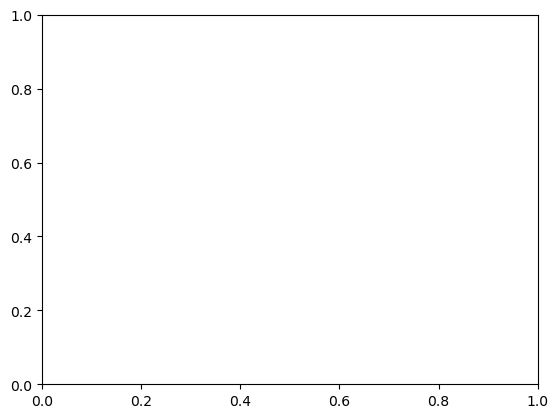

In [1]:
# laod modules 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import regionmask 

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github .com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'
outdir = '/project/s1207/ivanderk/scratch/'

figdir = '/users/ivanderk/notebooks_4p1000/figures/'

outdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/'
figdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_BG/figures/'
datadir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_data_topublish/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = 'high'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'


case   = case_ctl
block  = 'lnd' 
stream = 'h0' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ["H2OSOI", "watsat", "watfc"]

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 # 2028 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

proj =  ccrs.Robinson()


## 2. Load data

### Load simulations

In [4]:
ds_ctl = import_case(case_ctl, myVars=variables, timeSlice=time_slice)

ds_scen = import_case(case_scen, myVars=variables, timeSlice=time_slice)

ds_delta = ds_scen - ds_ctl 

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [5]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']
case_ctl_forinputdata = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl_forinputdata)

# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

### Plotting settings

In [6]:
## settings

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

plotting_depth = 2 # m 8
figsize = (17,38)
labels = ['a.','b.','c.','d.','e.','f.','g.']

## 3. Analysis & plotting

### Plot changes in field capacity and wilting point (appendix fig)

In [7]:
# delta field capacity
da_fc_ctl =  ds_ctl['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'}).load()
da_fc_scen =  ds_scen['watfc'][:,0:10,:,:].rename({'levgrnd':'levsoi'}).load()

da_delta_fc = (da_fc_scen - da_fc_ctl)
da_delta_fc_rel = (da_delta_fc/abs(da_fc_ctl)).weighted(da_delta_fc['levsoi']).mean(dim='levsoi').mean('time')*100
da_delta_fc_mean = da_delta_fc.weighted(da_delta_fc['levsoi']).mean(dim='levsoi').mean('time')


da_delta_wp = (da_wilting_h2osoi - da_wilting_h2osoi_scen)
da_delta_wp_rel = (da_delta_wp/abs(da_wilting_h2osoi)).weighted(da_wilting_h2osoi_scen['levsoi']).mean(dim='levsoi')*100
da_delta_wp_mean = da_delta_wp.weighted(da_wilting_h2osoi_scen['levsoi']).mean(dim='levsoi')

## absolute

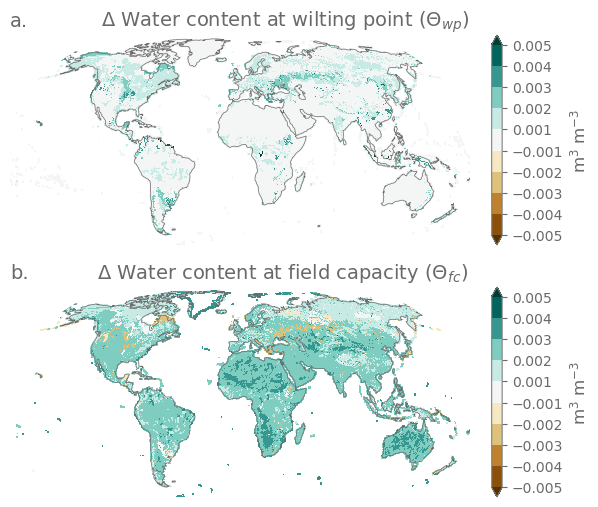

In [8]:
import matplotlib as mpl

mpl.rc('ytick',labelsize=10)


fig, axes = plt.subplots(2,1, figsize = (7,6) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_wp_mean
title = '$\Delta$ Water content at wilting point ($\Theta_{wp}$)'
levels = np.arange(-0.005,0.0051,0.001)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
# 
da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':'m$^3$ m$^{-3}$', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# saving
da_delta_wp_mean.where(landmask).to_dataset(name=da_delta_wp_mean.name).to_netcdf(datadir+'delta_wiltingpoint_'+scenario+'-CTL.nc')

# delta field capacity
ax = axes[1]
label = labels[1]
da_toplot = da_delta_fc_mean
title = '$\Delta$ Water content at field capacity ($\Theta_{fc}$) '

# levels=levels, 
da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both', levels=levels,  cbar_kwargs={'label':'m$^3$ m$^{-3}$', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# saving
da_delta_fc_mean.where(landmask).to_dataset(name=da_delta_fc_mean.name).to_netcdf(datadir+'delta_fieldcapacity_'+scenario+'-CTL.nc')

fig.tight_layout()
fig.savefig(figdir+'wilting_point_field_capacity.png', bbox_inches='tight')

## Relative (not used)

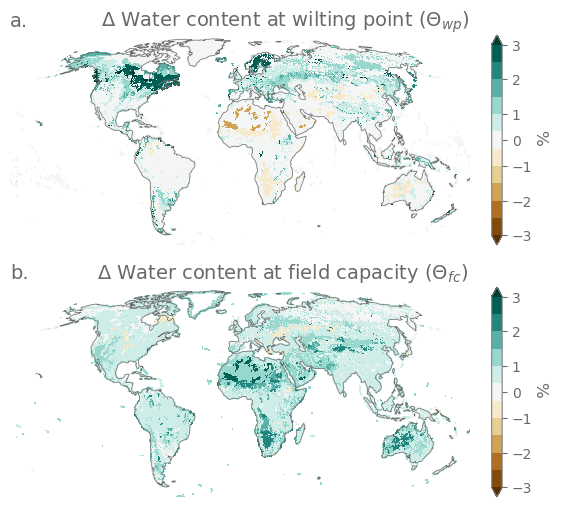

In [9]:
vlims=[-10,10]

fig, axes = plt.subplots(2,1, figsize = (7,6) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_wp_rel
title = '$\Delta$ Water content at wilting point ($\Theta_{wp}$)'
levels = np.arange(-2,2.5,0.5)
levels = np.arange(-3,3.5,0.5)
ticks =  np.arange(-3,4,1)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,   cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


# delta saturated water content
ax = axes[1]
label = labels[1]
da_toplot = da_delta_fc_rel
title = '$\Delta$ Water content at field capacity ($\Theta_{fc}$) '
levels = np.arange(-3,3.5,0.5)
#levels = np.arange(-2,2.5,0.5)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks =  np.arange(-3,4,1)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels, cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


fig.tight_layout()
fig.savefig(figdir+'wilting_point_field_capacity_relative.png', bbox_inches='tight')

### Plot change in water holding capacity, saturated fraction and volumetric water content

In [28]:
# calculate difference in water holding capacity. 

# First extract the variable, then slice
da_fc_ctl = ds_ctl['watfc'].isel(levgrnd=slice(0,10)).rename({'levgrnd':'levsoi'}).mean('time').load()
da_fc_scen = ds_scen['watfc'].isel(levgrnd=slice(0,10)).rename({'levgrnd':'levsoi'}).mean('time').load()
da_fc_scen = da_fc_scen.assign_coords(levsoi=da_wilting_h2osoi_scen['levsoi'])
da_whc_ctl =  (da_fc_ctl - da_wilting_h2osoi)
da_whc_scen = (da_fc_scen  - da_wilting_h2osoi_scen)

# delta wilting point
da_delta_whc =  da_whc_scen - da_whc_ctl
da_delta_whc_rel = (da_delta_whc/abs(da_whc_ctl)*100).weighted(da_delta_whc['levsoi']).mean(dim='levsoi').compute()
da_delta_whc_abs = da_delta_whc.weighted(da_delta_whc['levsoi']).mean(dim='levsoi').compute()

# calculate saturated fraction
da_h2o_ctl  =  ds_ctl['H2OSOI'][:,0:10,:,:]
da_h2o_scen =  ds_scen['H2OSOI'][:,0:10,:,:]

da_delta_h2o = da_h2o_scen - da_h2o_ctl
da_delta_h2o_rel =  ((da_delta_h2o / abs(da_h2o_ctl)).weighted(da_delta_h2o['levsoi']).mean(dim='levsoi').mean('time')*100).compute()
da_delta_h2o_abs = da_delta_h2o.weighted(da_delta_h2o['levsoi']).mean(dim='levsoi').mean('time').compute()


# water content at saturation
da_sat_ctl =  ds_ctl['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})
da_sat_scen =  ds_scen['watsat'][:,0:10,:,:].rename({'levgrnd':'levsoi'})

da_satfrac_ctl = da_h2o_ctl/da_sat_ctl
da_satfrac_scen = da_h2o_scen/da_sat_scen

da_delta_satfrac =  (da_satfrac_scen - da_satfrac_ctl)
da_delta_satfrac_rel =  ((da_delta_satfrac / abs(da_satfrac_ctl)).weighted(da_delta_satfrac['levsoi']).mean(dim='levsoi').mean('time')*100).compute()
da_delta_satfrac_abs = da_delta_satfrac.weighted(da_delta_satfrac['levsoi']).mean(dim='levsoi').mean('time').compute()

da_delta_sat = da_sat_scen - da_sat_ctl 
da_delta_sat_rel =  ((da_delta_sat / abs(da_sat_ctl)).weighted(da_delta_sat['levsoi']).mean(dim='levsoi').mean('time')*100).compute()


da_whcsat_ctl =  (da_sat_ctl - da_wilting_h2osoi)
da_sat_scen['lat'] = da_wilting_h2osoi_scen.lat
da_wilting_h2osoi_scen['levsoi'] = da_sat_ctl.levsoi

da_whcsat_scen = (da_sat_scen.compute() - da_wilting_h2osoi_scen)

da_delta_whcsat =  da_whcsat_scen - da_whcsat_ctl
da_delta_whcsat = da_delta_whcsat.weighted(da_delta_whcsat['levsoi']).mean(dim='levsoi')
da_whcsat_ctl= da_whcsat_ctl.weighted(da_whcsat_ctl['levsoi']).mean(dim='levsoi')

### Absolute

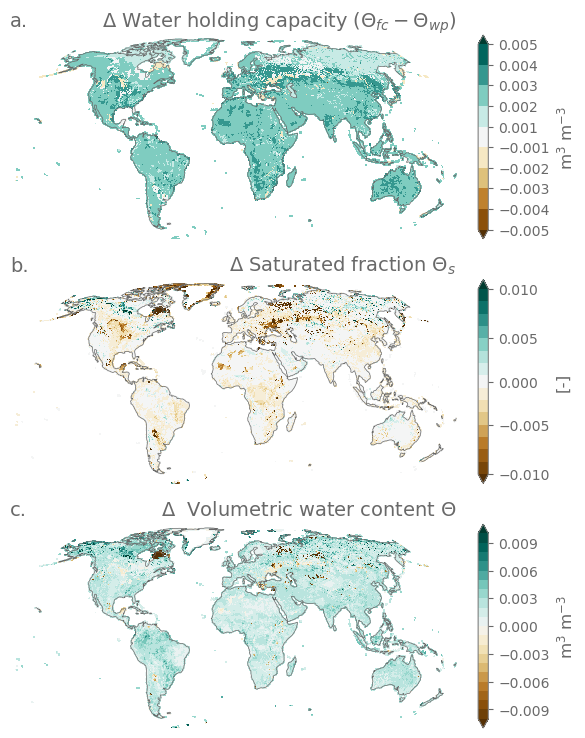

In [46]:
vlims=[-10,10]

fig, axes = plt.subplots(3,1, figsize = (7,9) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_whc_abs
title = '$\Delta$ Water holding capacity ($\Theta_{fc} - \Theta_{wp}$)'
levels = np.arange(-0.005,0.006,0.001)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))

ticks =  levels#np.arange(-0.005,0.0065,0.05)

#  levels=levels,
da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both', levels=levels, cbar_kwargs={'label':'m$^3$ m$^{-3}$', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# saving
da_delta_whc_abs.where(landmask).to_dataset(name='WaterHoldingCapacity').to_netcdf(datadir+'delta_waterholdingcapacity_'+scenario+'-CTL.nc')


# delta saturated water content
ax = axes[1]
label = labels[1]
da_toplot = da_delta_satfrac_abs
title = '$\Delta$ Saturated fraction $\Theta_{s}$ '
levels = np.arange(-1.5,1.75,0.25)
levels = np.arange(-0.01,0.01125,0.00125)

#levels = np.arange(-2,2.25,0.25)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks = np.arange(-0.01,0.015,0.005)
#, 'ticks' : ticks

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels, cbar_kwargs={'label':'[-]', 'fraction': 0.02, 'pad': 0.04, 'ticks' : ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# saving
da_delta_satfrac_abs.where(landmask).to_dataset(name='SaturatedFraction').to_netcdf(datadir+'delta_saturatedfraction_'+scenario+'-CTL.nc')


ax = axes[2]
label = labels[2]
da_toplot = da_delta_h2o_abs
title = '$\Delta$  Volumetric water content $\Theta$'
levels = np.arange(-1,1.1,0.1)
levels = np.arange(-2,2.25,0.25)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
levels = np.arange(-0.01,0.011,0.001)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',   levels=levels, cbar_kwargs={'label':'m$^3$ m$^{-3}$', 'fraction': 0.02, 'pad': 0.04}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# saving
da_delta_h2o_abs.where(landmask).to_dataset(name=da_delta_h2o_abs.name).to_netcdf(datadir+'delta_volumetricwatercontent_'+scenario+'-CTL.nc')


fig.tight_layout()
fig.savefig(figdir+'waterholdingcapacity.png', bbox_inches='tight')

In [53]:
da_delta_whc_abs.mean(dim=('lat','lon')).values

array(0.00228253)

In [54]:
da_delta_h2o_abs.mean(dim=('lat','lon')).values

array(0.00190308, dtype=float32)

### Relative

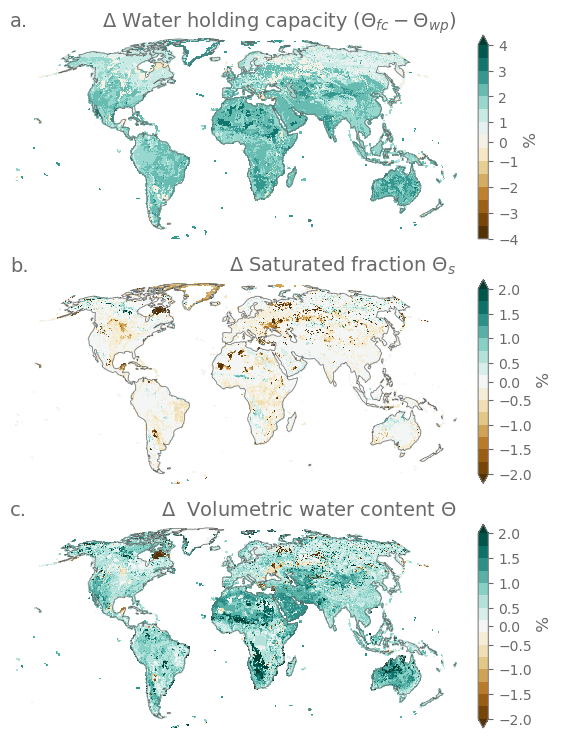

In [ ]:
vlims=[-10,10]

fig, axes = plt.subplots(3,1, figsize = (7,9) ,subplot_kw={'projection': proj, 'frameon':False})
axes = axes.flatten()

# delta water content
ax = axes[0]
label = labels[0]
da_toplot = da_delta_whc_rel
title = '$\Delta$ Water holding capacity ($\Theta_{fc} - \Theta_{wp}$)'
levels = np.arange(-20,22.5,2.5)
levels = np.arange(-4,4.5,0.5)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks = np.arange(-4,5,1)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='max', levels=levels, cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04, 'ticks' : ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


# delta saturated water content
ax = axes[1]
label = labels[1]
da_toplot = da_delta_satfrac_rel
title = '$\Delta$ Saturated fraction $\Theta_{s}$ '
levels = np.arange(-1.5,1.75,0.25)
levels = np.arange(-1,1.,0.1)

#levels = np.arange(-2,2.25,0.25)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks = np.arange(-1,1.1,0.5)
levels = np.arange(-2,2.25,0.25)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks = np.arange(-2,2.25,0.5)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04, 'ticks' : ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


ax = axes[2]
label = labels[2]
da_toplot = da_delta_h2o_rel
title = '$\Delta$  Volumetric water content $\Theta$'
levels = np.arange(-1,1.1,0.1)
levels = np.arange(-2,2.25,0.25)
levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
ticks = np.arange(-2,2.25,0.5)

da_toplot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', extend='both',  levels=levels,  cbar_kwargs={'label':' %', 'fraction': 0.02, 'pad': 0.04, 'ticks' : ticks}, add_labels=False)
ax.set_title(title, loc='right')
ax.set_title(label, loc='left')

ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')


fig.tight_layout()
fig.savefig(figdir+'waterholdingcapacity_relative.png', bbox_inches='tight')